In [1]:
%load_ext cython

In [2]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

The function `kernel(x, q)` below computes the integral kernel
$$K_q(x)=\frac{\exp(-x^2/2) E_1(x^2/2)}{|\Delta_q(x)|^2},$$
where the dispersion function
$$\Delta_q(x)=1-q^2 W(x).$$
Here,
$$q=k_{\mathrm{J}}/k$$
is the dimensionless wavelength. Note that $\Delta_q(x)$ attains its vacuum value in the limit of infinitely short wavelength, i.e. $\Delta_0(x)=1$.

$W(z)$ is the plasma dispersion function as defined by Ichimaru (1973). It is given by
$$W(z)=\frac{1}{\sqrt{2\pi}}\int_{-\infty}^\infty\mathrm{d}x\,\frac{\exp(-x^2/2)}{x - z}$$
for $\mathrm{Im}\,z>0$ and through analytic continuation for $\mathrm{Im}\,z\le 0$.

In [3]:
from math import pi, sqrt, exp

def W(z):
    ζ = sqrt(0.5)*z
    return 1 + 1j*sqrt(pi)*ζ*sp.special.wofz(ζ)

def kernel(x, q):
    Δ = 1 - q*q*W(x)
    return exp(-0.5*x*x)*sp.special.exp1(0.5*x*x)/abs(Δ)**2

Below is a Cython implementation of the same function. This can be passed to `scipy.integrate.quad`, which then runs a lot faster. Note that on the real axis, the real and imaginary parts of $W(x)$ are given by
$$\mathrm{Re}\,W(x) = 1 - \sqrt{2}\,x\,F\left(\frac{x}{\sqrt{2}}\right)$$
and
$$\mathrm{Im}\,W(x) = i\sqrt{\frac{\pi}{2}}\,x\,\exp\left(-\frac{x^2}{2}\right),$$
where
$$F(x)=\exp(-x^2)\int_0^x\mathrm{d}t\,\exp(t^2)$$
is Dawson's function.

In [4]:
%%cython

from cpython.pycapsule cimport PyCapsule_New

import cython
from libc.math cimport pi, sqrt, exp
from scipy.special.cython_special cimport dawsn, exp1

@cython.cdivision(True)
cdef double c_kernel(int n, double[2] args):

    cdef double x, q, xi, F, W_r, W_i, D_r, D_i

    x = args[0]
    q = args[1]

    xi = sqrt(0.5)*x

    W_r = 1 - 2*xi*dawsn(xi)
    W_i = sqrt(pi)*xi*exp(-xi*xi)

    D_r = 1 - q*q*W_r
    D_i =   - q*q*W_i

    return exp(-xi*xi)*exp1(xi*xi)/(D_r*D_r + D_i*D_i)


def kernel_fast(x, q):

    cdef double[2] args

    args[0] = x
    args[1] = q

    return c_kernel(2, args)


def get_LowLevelCallable():

    from scipy import LowLevelCallable

    func_capsule = PyCapsule_New(<void*>c_kernel, "double (int, double *)", NULL)

    return LowLevelCallable(func_capsule)

Make sure the Cython version gives the same result as the pure Python version.

In [5]:
for i in range(10):
    x = np.random.randn()
    q = np.random.rand()
    assert np.isclose(kernel(x, q), kernel_fast(x, q))

The following function computes the dimensionless relaxation rate
$$\frac{\Gamma}{k_{\mathrm{J}}\sigma\mu}=\sum_{\boldsymbol{n}\ne 0} q^3\int_0^\infty\mathrm{d}x\,K_q(x),$$
where the integral kernel $K_q(x)$ is defined above. The sum over wavenumbers $\boldsymbol{n}$ is computed as follows.

We suppose that the stellar system is contained inside a periodic cube of volume $L^3$. The wavevectors are then given by
$$\boldsymbol{k}=\frac{2\pi}{L}\boldsymbol{n}.$$
The magnitude of the wavevector, i.e. $k=|\boldsymbol{k}|$, is obviously
$$k=\frac{2\pi}{L}n.$$
Given this, the dimensionless wavelength $q=k_{\mathrm{J}}/k$ can be written as
$$q=\frac{L}{\lambda_{\mathrm{J}}}\frac{2\pi/L}{k}=\frac{q_0}{n},$$
where $\lambda_{\mathrm{J}}=2\pi/k_{\mathrm{J}}$ is the Jeans length. The above equation serves as the definition of the dimensionless box size $q_0=L/\lambda_{\mathrm{J}}$.

The function below sums over all wavenumbers $\boldsymbol{n}$ satisfying $0<n<5$. It computes both the *dressed* relaxation rate as defined above and the *vacuum* relaxation rate
$$\frac{\Gamma_0}{k_{\mathrm{J}}\sigma\mu}=\sum_{\boldsymbol{n}\ne 0} q^3\int_0^\infty\mathrm{d}x\,K_0(x),$$
which neglects self-gravity. The integral over $x$ can be taken out of the sum over $\boldsymbol{n}$.

100%
Maximum error: 6.411005074369314e-06


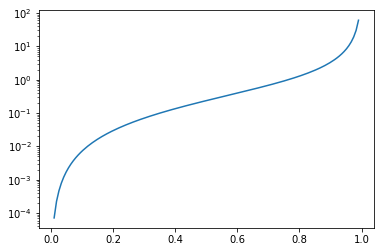

In [6]:
# Maximum magntitude of the wavenumber
nmax = 5

# Get a vector of squared wavenumbers |n|² that satisfy 0 < nx**2 + ny**2 + nz**2 <= nmax**2.
n2 = []
for nx in range(-nmax, nmax + 1):
    for ny in range(-nmax, nmax + 1):
        for nz in range(-nmax, nmax + 1):
            n2.append(nx*nx + ny*ny + nz*nz)
n2 = np.array(n2)
mask = np.logical_or(n2 == 0, n2 > nmax*nmax)
n2_compressed = np.ma.masked_where(mask, n2).compressed()

# Sort the squared wave numbers
n2_sorted = np.sort(n2_compressed)

# Inverse of the magnitude of the wavenumbers
ninv = 1/np.sqrt(n2_sorted)

# Array of dimensionless box sizes
q0 = np.linspace(0.01, 0.99, 128)

# Arrays to hold the dressed and bare relaxation rates
Γ = np.zeros_like(q0)
Γ0 = np.zeros_like(q0)

max_error = 0

# Get the fast, Cython-based integral kernel
cython_kernel = get_LowLevelCallable()

# Loop over box sizes
for j in range(q0.size):

    # Sum over wavenumbers
    for n1 in ninv:

        # Dimensionless inverse wavenumber
        q = q0[j]*n1

        # Short hand
        q3 = q**3

        # Dressed relaxation rate per wavenumber
        dressed, error = sp.integrate.quad(cython_kernel, 0.0, np.inf, args=(q,))
        max_error = max(error, max_error)
        Γ[j] += q3*dressed

        # Vacuum relaxation rate per wavenumber. First factor ...
        Γ0[j] += q3

    # ... and second factor
    bare, error = sp.integrate.quad(cython_kernel, 0.0, np.inf, args=(0,))
    max_error = max(error, max_error)
    Γ0[j] *= bare

    print("\r{:.0%}".format((j+1)/q0.size), end='', flush=True)

print("\nMaximum error: {}".format(max_error))

# Plot the ratio of dressed to vacuum relaxation rate
plt.semilogy(q0, Γ/Γ0 - 1);